In [1]:
# importing necessary libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pwd

'C:\\Users\\trini\\stats\\stats_CA'

In [66]:
# load the dataset using pandas function into dataframe from csv file
ts_file = pd.read_csv("ts8.csv",index_col="Unnamed: 0")
# or ts_file.set_index(['Unnamed: 0'])
ts_file.rename(columns={'Unnamed: 0' : 'time_ID', "x" : "time_value"}, inplace=True)
ts_file.head()

,time_value
1,132.639999
2,132.690002
3,134.380005
4,134.410004
5,135.300003


In [67]:
ts_file.columns

Index(['time_value'], dtype='object')

In [64]:
ts_file.shape

(301, 1)

In [62]:
ts_file.isnull().sum()

time_value    0
dtype: int64

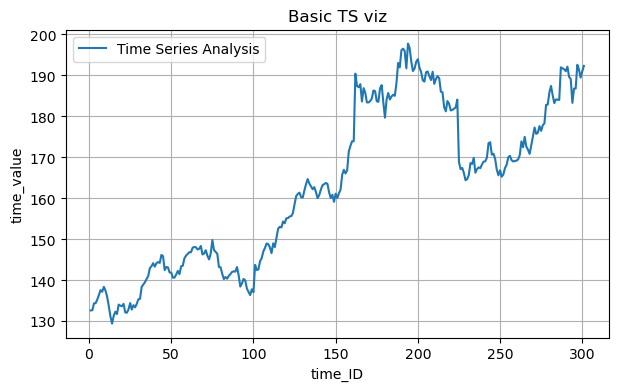

In [61]:
# plot the time series
plt.figure(figsize=(7,4))
plt.plot(ts_file, label = "Time Series Analysis")
plt.title("Basic TS viz")
plt.xlabel("time_ID")
plt.ylabel("time_value")
plt.legend()
plt.grid()
plt.show()

In [68]:
# Trend Analysis using seasonal decomposition
# using additive for primary check
from statsmodels.tsa.seasonal import seasonal_decompose
decomp_data = seasonal_decompose(ts_file["time_value"], model="additive", period=10)
trend = decomp_data.trend
seasonal = decomp_data.seasonal
residual = decomp_data.resid

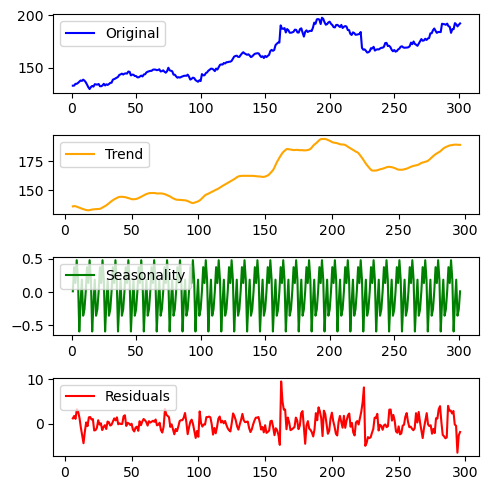

In [69]:
# Plot the decomposition
plt.figure(figsize=(5, 5))
plt.subplot(411)
plt.plot(ts_file['time_value'], label='Original', color='blue')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residuals', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

1. check stationarity on the data - mean should be constant. in this case, there is an increase of data points, hence indicating mean also increases.
2. there are 2 tests that help in checking the stationarity of the data
3. rolling statistics and ADCF method

In [6]:
# 1. determining the rolling statistics - define 2 vars
roll_mean = ts_file.rolling(window=12).mean() #window meaning 12 months - gives the rolling mean at yearly level
roll_std = ts_file.rolling(window=12).std() #following the same step as above to obtain the standard deviation
print(f'roll_mean : \n{roll_mean}\n')
print(f'roll_stdev : \n{roll_std}')

roll_mean : 
     time_value
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
..          ...
297  189.227500
298  189.846666
299  189.638332
300  189.574999
301  189.643333

[301 rows x 1 columns]

roll_stdev : 
     time_value
1           NaN
2           NaN
3           NaN
4           NaN
5           NaN
..          ...
297    3.253411
298    2.854862
299    2.775135
300    2.730882
301    2.792983

[301 rows x 1 columns]


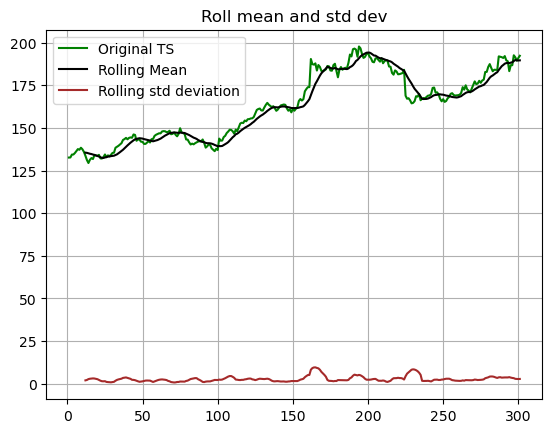

In [70]:
# plotting the rolling statistics value
org = plt.plot(ts_file, color='green', label = 'Original TS')
mean = plt.plot(roll_mean, color='black', label = 'Rolling Mean')
std = plt.plot(roll_std, color='brown', label = 'Rolling std deviation')
plt.legend(loc='best')
plt.title('Roll mean and std dev')
plt.grid()
plt.show(block=False)

In [30]:
# 2. perform dickey-fuller test using the adfuller function
from statsmodels.tsa.stattools import adfuller
print('Results of DF test')
df_test = adfuller(ts_file['time_value'],autolag='AIC') # lag is set to A information criterion that shows the exact values and actual values and is analysed on the differences between them 
df_test

df_output = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', '#lags used',
                                           'No. of obs'])
for key, value in df_test[4].items():
    df_output['Critical value (%s) '%key] = value
print(df_output)

Results of DF test
Test Statistic            -1.005504
p-value                    0.751251
#lags used                 0.000000
No. of obs               300.000000
Critical value (1%)       -3.452337
Critical value (5%)       -2.871223
Critical value (10%)      -2.571929
dtype: float64


Analysis on the above:
1. Null Hypothesis says that p-value must always be less ~ 0.5, would be great
2. critical value should be more that the test statistic. in this case we cannot reject the null hypothese and say that the data is not stationary.
Hence we estimate the trend

In [31]:
# apply differencing to make the series stationary
ts_diff['diff'] = ts_file['time_value'].diff().dropna()
ts_diff['diff']

2      0.050003
3      1.690002
4      0.029999
5      0.889999
6      1.119995
         ...   
297    5.809998
298   -1.160004
299   -1.970001
300    1.510010
301    1.330002
Name: time_value, Length: 300, dtype: float64

In [37]:
# ADF test on differenced data
result_diff = adfuller(ts_diff['diff'].dropna())
print('ADF Statistic after differencing:', result_diff[0]) 
print('p-value after differencing:', result_diff[1])
result_diff

ADF Statistic after differencing: -18.291707630192576
p-value after differencing: 2.296587604957597e-30


(-18.291707630192576,
 2.296587604957597e-30,
 0,
 299,
 {'1%': -3.4524113009049935,
  '5%': -2.8712554127251764,
  '10%': -2.571946570731871},
 1265.5947481921066)

<Figure size 200x300 with 0 Axes>

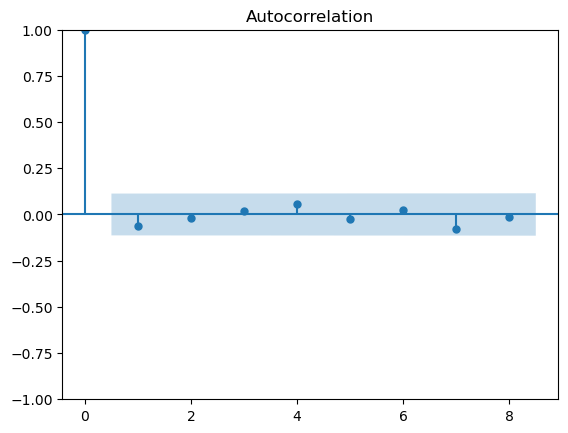

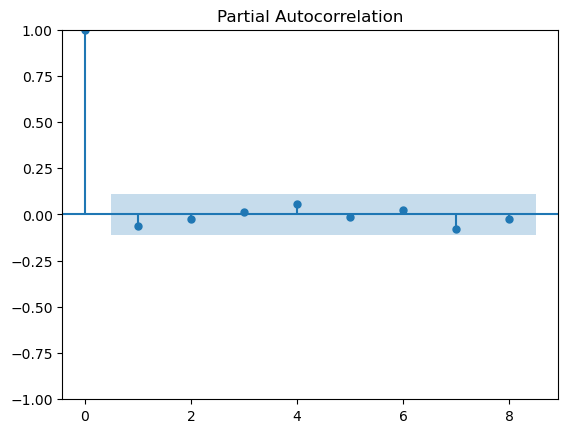

In [72]:
# Plotting ACF AND PACF 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.arima.model import ARIMA
plt.figure(figsize=(2,3))
plot_acf(ts_diff['diff'].dropna(), lags=8)
# plt.subplot(611)
plot_pacf(ts_diff['diff'].dropna(), lags=8)
# plt.subplot(611)
plt.show()

In [82]:
# fitting the ARIMA MODEL
import warnings
warnings.filterwarnings('ignore')
model=ARIMA(ts_file['time_value'],order=(1,1,1))
fit=model.fit()
fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             time_value   No. Observations:                  301
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -665.177
Date:                Fri, 22 Nov 2024   AIC                           1336.355
Time:                        17:09:39   BIC                           1347.466
Sample:                             0   HQIC                          1340.802
                                - 301                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0704      1.488      0.047      0.962      -2.846       2.986
ma.L1         -0.1228      1.476     -0.083      0.934      -3.015       2.769
sigma2         4.9361      0.142     34.663      0.000       4.657       5.215
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              3467.62
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               3.02   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
# forecasting
forecast = fit.forecast(steps=3)
forecast

301    192.242229
302    192.236754
303    192.236369
Name: predicted_mean, dtype: float64

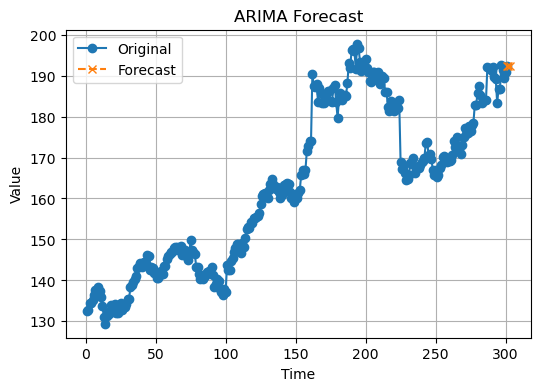

In [57]:
plt.figure(figsize=(6, 4))
plt.plot(ts_file['time_value'], marker='o', label='Original') 
plt.plot(forecast, marker='x', label='Forecast', linestyle='--')
plt.title('ARIMA Forecast')  
plt.xlabel('Time') 
plt.ylabel('Value') 
plt.legend() 
plt.grid(True)

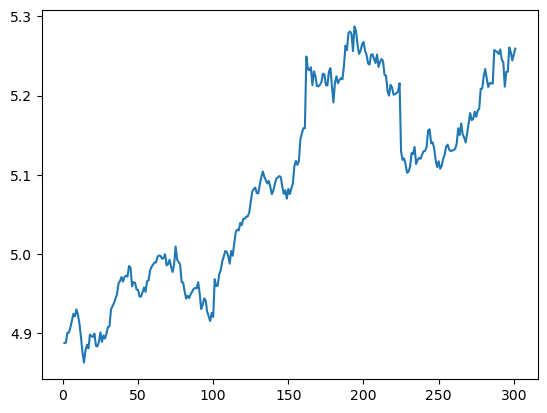

In [10]:
# estimating the trend - log of the dataset
log = np.log(ts_file)
plt.plot(log)


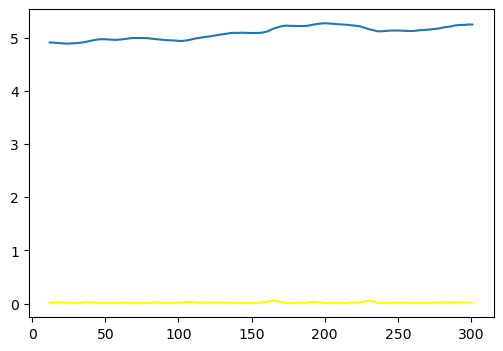

In [73]:
# moving average - but this time with the log timeseries
mov_avg = log.rolling(window=12).mean()
mov_std = log.rolling(window=12).std()
# plotting graph with log time series
plt.figure(figsize=(6,4))
plt.plot(mov_avg)
plt.plot(mov_std, color = 'yellow')

If data is still not stationary, we get the diff b/w moving avg and std deviation.
Reason as to why we perform these tests is to get the time series data stationary.


In [14]:
log_diff = log - mov_avg
log_diff.head(12)

# removing NAN values
log_diff.dropna(inplace=True)
log_diff

,time_value
12,-0.013456
13,-0.031557
14,-0.042838
15,-0.026282
16,-0.017403
...,...
297,0.017854
298,0.008515
299,-0.000736
300,0.007532


ANALYSIS ON THE ABOVE:
1. p-value is still higher (need to check)
2. critical value should be ~ test statistic

In [18]:
#trend detection - by using rolling mean to observe trends exhibited in data
from statsmodels.tsa.seasonal import seasonal_decompose
roll_threshold = 10
ts_file["Rolling Mean"] = ts_file["time_value"].rolling(window=roll_threshold).mean()
ts_file

,time_value,Rolling Mean
1,132.639999,NaN
2,132.690002,NaN
3,134.380005,NaN
4,134.410004,NaN
5,135.300003,NaN
...,...,...
297,192.610001,189.473000
298,191.449997,189.442999
299,189.479996,189.240999
300,190.990005,189.236000


Text(0.5, 1.0, 'Trend detection with rolling mean')

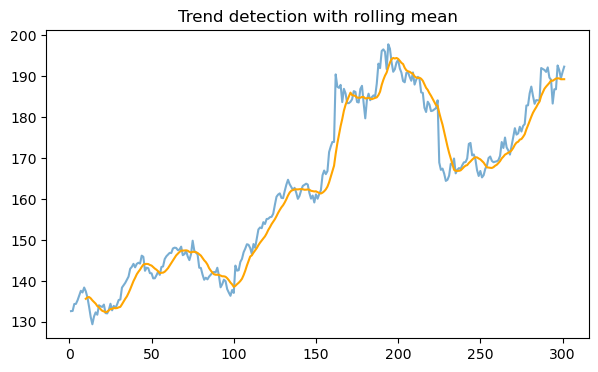

In [19]:
# plot original data with rolling mean
plt.figure(figsize=(7,4))
plt.plot(ts_file["time_value"], label='Original TS Viz', alpha=0.6)
plt.plot(ts_file["Rolling Mean"], label=f"{roll_threshold}point roll mean", color='orange')
plt.title("Trend detection with rolling mean")

In [7]:
# naive modelling
ts_file_naive = pd.read_csv("ts8.csv", index_col="Unnamed: 0")
ts_file_naive

,x
1,132.639999
2,132.690002
3,134.380005
4,134.410004
5,135.300003
...,...
297,192.610001
298,191.449997
299,189.479996
300,190.990005


In [9]:
ts_file_naive.columns=['time_x']
ts_file_naive

,time_x
1,132.639999
2,132.690002
3,134.380005
4,134.410004
5,135.300003
...,...
297,192.610001
298,191.449997
299,189.479996
300,190.990005


In [17]:
# applying naive modelling by shifting the values
ts_file_naive['pred_values'] = ts_file_naive["time_x"].shift(1)
ts_file_naive['pred_values']

2             NaN
3      132.690002
4      134.380005
5      134.410004
6      135.300003
          ...    
297    186.800003
298    192.610001
299    191.449997
300    189.479996
301    190.990005
Name: pred_values, Length: 300, dtype: float64

In [14]:
# dropping null values:
ts_file_naive.dropna(inplace=True)
ts_file_naive.isnull().sum()

time_x         0
pred_values    0
dtype: int64

In [15]:
# calculating the error metrics
from sklearn.metrics import mean_squared_error, r2_score
naive_rmse = np.sqrt(mean_squared_error(ts_file_naive["time_x"], ts_file_naive["pred_values"]))
print(f"naive rmse : {naive_rmse}")

naive rmse : 2.2248717978903314


In [16]:
# r2 score
naive_r2 = r2_score(ts_file_naive["time_x"], ts_file_naive["pred_values"])
print(f"naive r2 : {naive_r2}")

naive r2 : 0.9872511698764501


Interpretation of the above: both rmse and r2 score values indicate that the model is performing well.
The lower the rmse values, the better - meaning since the time series values range between 200 and 500 the obtained rmse values are relatively lower, implying less error between actual values and predicted ones.
Higher the r2 score, indicates that the model is able to capture latge variability in the data.

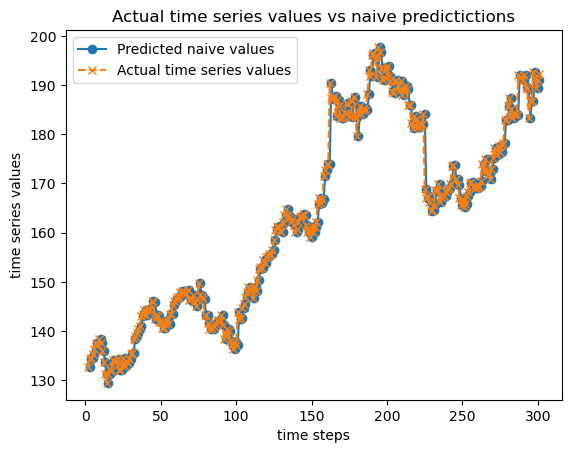

In [21]:
# visualisation between actual values and naive forecast
plt.plot(ts_file_naive["pred_values"], label='Predicted naive values', marker='o')
plt.plot(ts_file_naive["time_x"], label="Actual time series values", linestyle='--',marker='x')
plt.title("Actual time series values vs naive predictictions")
plt.xlabel("time steps")
plt.ylabel("time series values")
plt.legend()
plt.show()